<a href="https://colab.research.google.com/github/sakurasakura1996/Pytorch-start-learning/blob/master/Dive_into_DL_Pytorch_2_3%E8%87%AA%E5%8A%A8%E6%B1%82%E6%A2%AF%E5%BA%A6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In deep learning,我们经常需要对函数求梯度。 Pytorch提供的autograd包能够根据输入和前向传播过程自动构建计算图，并执行反向传播。 这节将介绍
# 2.3自动求梯度
## 2.3.1 概念
上一节介绍的Tensor类是autograd包的核心类，如果将其属性 .requires_grad设置为True,它将开始追踪在其上的所有操作(这样就可以利用链式法则进行梯度传播了)完成计算后，可以调用 .backward()来完成所有梯度的计算。次Tensor的梯度将累计到其 .grad属性中。

*注意在y.backward()时，如果y是标量，则不需要为backward()传入任何参数；否则，需要转入一个与y同形状的tensor。解释见2.3.2小节*

如果不想要被继续追踪，可以调用 .detach()将其从追踪记录中分离出来，这样就可以防止将来的计算被追踪，这样梯度就传不过去了。此外还可以用 with torch.no_grad()将不想被追踪的操作代码块包裹起来，这种放在在评估模型的时候很常用。因为在评估模型时我们并不需要计算可训练参数的梯度

Function是另一个重要的类。Tensor和Function互相结合就可以构建一个记录有整个计算过程的有向无环图DAG，每个Tensor都有一个  .grad_fn 属性，该属性即创建该Tesnsor的Function，就是说该Tensor是不是通过某些运算得到的，若是，则grad_fn返回一个与这些运算相关的对象，否则是None
## 2.3.2 Tensor


In [5]:
# 创建一个tensor 并设置 requires_grad=True
import torch
x = torch.ones(2, 2, requires_grad=True)
print(x)
print(x.grad_fn)   # 现在x是创建的，并不是通过运算得来的

y = x+2
print(y)
print(y.grad_fn)   # 这里的y就是通过上面的加法运算而来，所以grad_fn属性值为 True（实际返回为具体的运算对象)

# 像x这种直接创建出来的称为叶子节点，叶子节点对应的grad_fn为None  可以用tensor.is_leaf来判断是否是叶子节点
print(x.is_leaf,y.is_leaf)

# 复杂点的例子
z = y*y*3
out = z.mean()
print(z,out)



tensor([[1., 1.],
        [1., 1.]], requires_grad=True)
None
tensor([[3., 3.],
        [3., 3.]], grad_fn=<AddBackward0>)
True False
tensor([[27., 27.],
        [27., 27.]], grad_fn=<MulBackward0>) tensor(27., grad_fn=<MeanBackward0>)


In [6]:

# 通过 .requires_grad_()来用In-place 的方式改变 requires_grad属性
a = torch.randn(2, 2)    # 缺失情况下默认 requires_grad = False
a = ((a * 3) / (a-1))
print(a.requires_grad)
a.requires_grad_(True)
print(a.requires_grad)
b = (a*a).sum()
print(b.grad_fn)

False
True


## 2.3.2 梯度
因为上面的out是一个标量，所以调用backward()时不需要指定求导变量
out.backward() 等价于 out.backward(torch.tensor(1.))
我们可以来看看out关于x的梯度
print(x.grad)

In [7]:
out.backward()
print(x.grad)

tensor([[4.5000, 4.5000],
        [4.5000, 4.5000]])


张量都为向量的函数 y = f(x) 那么y关于x 的梯度就是一个雅可比矩阵
而torch.autograd 这个包就是用来计算一些雅可比矩阵的乘积的。
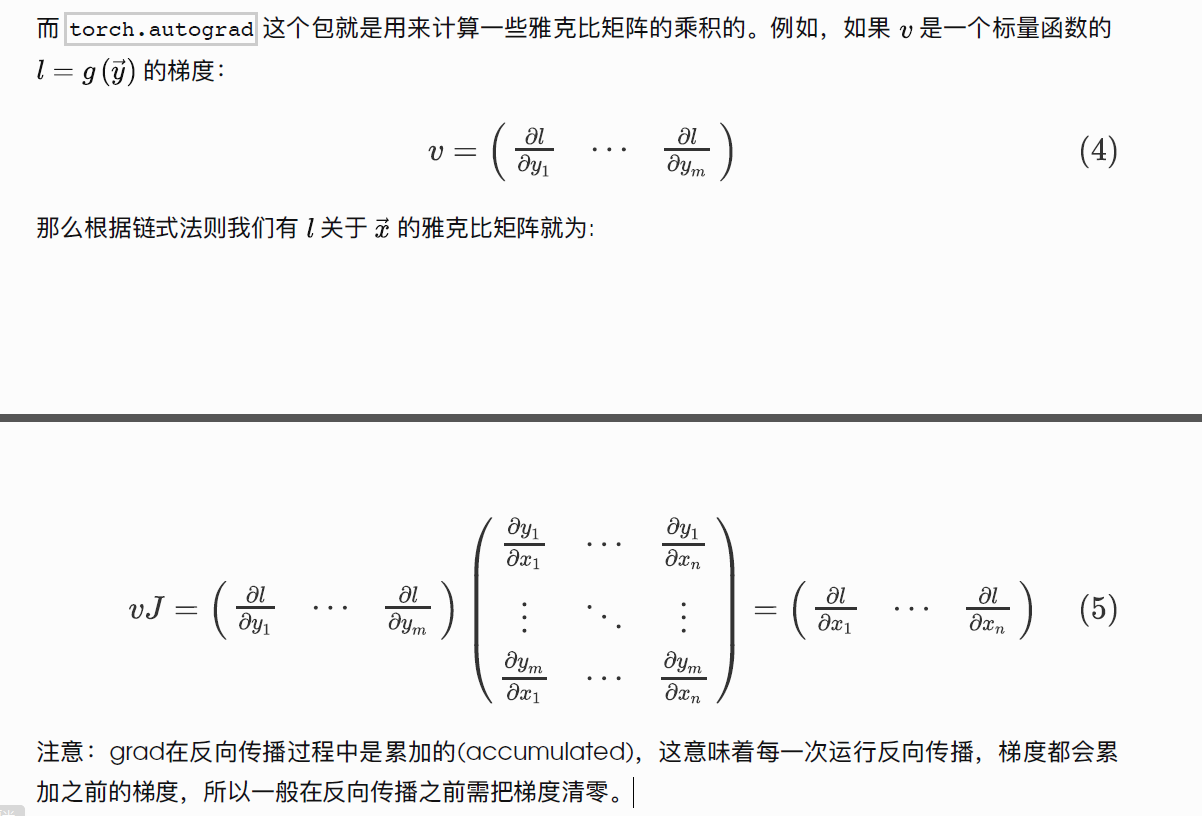


In [8]:
# 再来反向传播一次，注意grad是累加的
out2 = x.sum()
out2.backward()
print(x.grad)   # 原来x的梯度值已经是4.5了，现在是x.sum()  out2 关于x的梯度是1，grad是累加的，所以输出结果为5.5

out3 = x.sum()
x.grad.data.zero_()
out3.backward()
print(x.grad)


tensor([[5.5000, 5.5000],
        [5.5000, 5.5000]])
tensor([[1., 1.],
        [1., 1.]])


现在我们解释为什么2.3.2节留下来的问题为什么在y.backward()时，如果y是标量，则不需要为backward()传入任何参数；否则，需要传入一个与y同型的tensor？

简单来说就是为了避免向量（甚至高维向量）对张量求导，而转换成标量对张量求导。假设形状为(m,n)的矩阵x经过运算得到了(p,q)的矩阵y，y又经过运算得到了(s,t)的矩阵z，那么按照前面的规则，dz/dy 应该是一个s*t*p*q四维张量，dy/dx是一个p*q*m*n的四维张量。那么怎么反向传播，怎样将四维向量相乘？？这要怎么乘？所以问题在这，避免这个问题，我们不允许张量对张量求导，只允许标量对张量求导，求导结果也就是和自变量同形的张量。所以必要时我们把张量通过将所有张量的元素加权求和的方式转换为标量。

举个例子
假设y由自变量x计算而来，w是和y同形的张量，则y.backward(w)的含义是：先计算l=torch.sum(y * w),则l是标量，然后求l对自变量x的导数。

In [3]:
import torch
x = torch.tensor([1.0,2.0,3.0,4.0],requires_grad=True)
y = 2 * x
z = y.view(2,2)
print(z)

tensor([[2., 4.],
        [6., 8.]], grad_fn=<ViewBackward>)


In [4]:
# 现在y不是一个标量，所以在调用backward时需要传入一个和y同形的权重向量进行加权求和得到一个标量。
v= torch.tensor([[1.0,0.1],[0.01,0.001]],dtype=torch.float)
z.backward(v)
print(x.grad)
# x.grad是和x同形的张量

tensor([2.0000, 0.2000, 0.0200, 0.0020])


In [7]:
# 再来看看中断梯度追踪的例子：
x = torch.tensor(1.0, requires_grad=True)
y1 = x ** 2
with torch.no_grad():
  y2 = x ** 3
y3 = y1 + y2
print(x.requires_grad)
print(y1, y1.requires_grad) # True
print(y2, y2.requires_grad) # False
print(y3, y3.requires_grad) # True
# 可以看到，上面的y2是没有grad_fn 而且 y2.requires_grad=False的，而y3是有grad_fn
# 的。如果我们将y3对x求梯度的话会是多少呢
y3.backward()
print(x.grad)
# 结果值为2，应该能理解，因为y2部分被设置了torch.no_grad()


True
tensor(1., grad_fn=<PowBackward0>) True
tensor(1.) False
tensor(2., grad_fn=<AddBackward0>) True
tensor(2.)


In [12]:
# 此外，如果我们想要修改tensor的数值，但是又不希望被autograd记录
# 也就是不希望会影响反向传播，那我们可以对tensor.data进行操作。
x = torch.ones(1,requires_grad=True)

print(x.data)    # 还是一个tensor
print(x.data.requires_grad)  # 但是已经是独立于计算图之外的了

y = 2 * x * x
y.backward()
x.data *= 100    # 只改变了tensor中的数值，不会记录在计算图中，所以不会影响梯度传播


print(x)      #更改data的值也会影响tensor的值
print(x.grad)

tensor([1.])
False
tensor([100.], grad_fn=<CopySlices>)
tensor([4.])
